In [5]:
import sqlite3

# Connect to SQLite database (or create if it doesn't exist)
conn = sqlite3.connect("simulation_results.db")
cursor = conn.cursor()

# Create table if not exists
cursor.execute('''
CREATE TABLE IF NOT EXISTS simulation_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    time REAL,
    voltage REAL
)
''')

# Open the output file and read the data
with open("keep the ngspice ouput generated file here ", "r") as file:
    lines = file.readlines()

# Extract relevant data (skip headers and non-data lines)
data = []
start_parsing = False  # Flag to detect when to start reading data

for line in lines:
    line = line.strip()
    if line.startswith("Index"):  # Detect header line
        start_parsing = True
        continue
    if start_parsing and line and not line.startswith("-"):  # Ignore empty or separator lines
        parts = line.split()
        if len(parts) == 3:  # Ensure correct number of columns
            try:
                index = int(parts[0])  # Index (not needed for DB)
                time = float(parts[1])  # Time value
                voltage = float(parts[2])  # Voltage value
                data.append((time, voltage))
            except ValueError:
                continue  # Skip invalid lines

# Insert data into the database
cursor.executemany("INSERT INTO simulation_data (time, voltage) VALUES (?, ?)", data)

# Commit and close connection
conn.commit()
conn.close()

print("Data successfully stored in SQLite database.")


Data successfully stored in SQLite database.


In [6]:
import sqlite3

conn = sqlite3.connect("simulation_results.db")
cursor = conn.cursor()

cursor.execute("SELECT * FROM simulation_data LIMIT 10")  # Fetch first 10 rows
rows = cursor.fetchall()

for row in rows:
    print(row)

conn.close()


(1, 1e-06, 0.004995)
(2, 2e-06, 0.009985)
(3, 4e-06, 0.01996)
(4, 8e-06, 0.03984)
(5, 1.6e-05, 0.07936)
(6, 3.2e-05, 0.1575)
(7, 6.4e-05, 0.31)
(8, 0.0001, 0.4758)
(9, 0.000106, 0.5046)
(10, 0.000119, 0.5618)


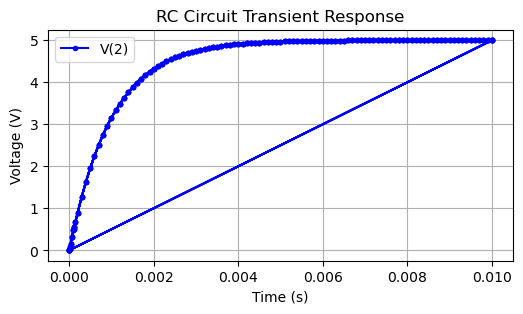

In [29]:
import sqlite3
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect("simulation_results.db")
cursor = conn.cursor()

# Retrieve data
cursor.execute("SELECT time, voltage FROM simulation_data")
data = cursor.fetchall()

# Close connection
conn.close()

# Extract time and voltage values
times = [row[0] for row in data]
voltages = [row[1] for row in data]

# Plot the data
plt.figure(figsize=(6, 3))
plt.plot(times, voltages, marker="o", linestyle="-", color="b", markersize=3, label="V(2)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("RC Circuit Transient Response")
plt.legend()
plt.grid()
plt.show()


In [9]:
import sqlite3
import numpy as np
import pandas as pd

# Define the database file
db_file = "circuit_data.db"

# Connect to the SQLite database (creates one if it doesn’t exist)
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# Create a table for circuit simulation data
cursor.execute('''CREATE TABLE IF NOT EXISTS circuit_simulation (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    resistor_ohms REAL,
                    capacitor_farads REAL,
                    supply_voltage REAL,
                    power_watts REAL,
                    frequency_hz REAL
                )''')

# Function to generate synthetic data
def generate_circuit_data(samples=5000):
    np.random.seed(42)  # For reproducibility
    
    resistor = np.random.uniform(100, 10000, samples)  # Resistance in ohms
    capacitor = np.random.uniform(1e-9, 1e-3, samples)  # Capacitance in farads
    supply_voltage = np.random.uniform(1, 10, samples)  # Voltage in volts
    
    # Derived parameters (Assumed for simulation)
    power = (supply_voltage ** 2) / resistor  # Power using P = V²/R
    frequency = 1 / (2 * np.pi * resistor * capacitor)  # Approximate cutoff frequency for RC circuit
    
    return np.column_stack((resistor, capacitor, supply_voltage, power, frequency))

# Generate the dataset
circuit_data = generate_circuit_data(10000)

# Insert data into the database
cursor.executemany('''INSERT INTO circuit_simulation (resistor_ohms, capacitor_farads, supply_voltage, power_watts, frequency_hz)
                      VALUES (?, ?, ?, ?, ?)''', circuit_data.tolist())

# Commit and close
conn.commit()
conn.close()

print("✅ Successfully stored 5000 circuit simulation samples in SQLite database!")

# Read and display the first 10 records
conn = sqlite3.connect(db_file)
df = pd.read_sql_query("SELECT * FROM circuit_simulation LIMIT 10", conn)
conn.close()

# Display the dataset
from IPython.display import display
display(df)  # Correct method to display data in Jupyter Notebook


✅ Successfully stored 5000 circuit simulation samples in SQLite database!


,id,resistor_ohms,capacitor_farads,supply_voltage,power_watts,frequency_hz
0,1,3807.947177,0.000374,7.569985,0.015049,0.111860
1,2,9512.071633,0.000333,2.660608,0.000744,0.050259
2,3,7346.740024,0.000176,4.119757,0.002310,0.122979
3,4,6026.718994,0.000607,6.969526,0.008060,0.043487
4,5,1644.584540,0.000477,5.338804,0.017331,0.203043
5,6,1644.345751,0.000866,7.647139,0.035564,0.111804
6,7,675.027760,0.000032,9.650871,0.137978,7.342615
7,8,8675.143843,0.000644,2.048920,0.000484,0.028494
8,9,6051.038616,0.000763,7.386109,0.009016,0.034474
9,10,7109.918520,0.000759,3.073097,0.001328,0.029474


In [14]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Connect to SQLite database
conn = sqlite3.connect('circuit_data.db')
query = "SELECT * FROM circuit_simulation;"
df = pd.read_sql_query(query, conn)
conn.close()

# Display the first few rows
print("Dataset Preview:")
print(df.head())



Dataset Preview:
   id  resistor_ohms  capacitor_farads  supply_voltage  power_watts  \
0   1    3807.947177          0.000374        7.569985     0.015049   
1   2    9512.071633          0.000333        2.660608     0.000744   
2   3    7346.740024          0.000176        4.119757     0.002310   
3   4    6026.718994          0.000607        6.969526     0.008060   
4   5    1644.584540          0.000477        5.338804     0.017331   

   frequency_hz  
0      0.111860  
1      0.050259  
2      0.122979  
3      0.043487  
4      0.203043  


In [15]:
# Feature Selection
features = ['resistor_ohms', 'capacitor_farads', 'supply_voltage']
target = 'power_watts'

X = df[features]
y = df[target]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest MSE: {rf_mse:.4f}')

# Train Neural Network (MLP Regressor)
nn_model = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=500, random_state=42)
nn_model.fit(X_train_scaled, y_train)
y_pred_nn = nn_model.predict(X_test_scaled)
nn_mse = mean_squared_error(y_test, y_pred_nn)
print(f'Neural Network MSE: {nn_mse:.4f}')

# Bayesian Optimization for Circuit Parameter Tuning
def objective_function(params):
    resistor, capacitor, voltage = params
    scaled_input = scaler.transform([[resistor, capacitor, voltage]])
    prediction = rf_model.predict(scaled_input)[0]
    return prediction  # Minimize power consumption

# Define search space
space = [
    Real(100, 10000, name='resistor_ohms'),
    Real(1e-9, 1e-3, name='capacitor_farads'),
    Real(1, 10, name='supply_voltage')
]

# Perform Bayesian Optimization
result = gp_minimize(objective_function, space, n_calls=20, random_state=42)

# Extract optimal values
optimal_resistor, optimal_capacitor, optimal_voltage = result.x
print(f'Optimized Resistor: {optimal_resistor:.2f} ohms')
print(f'Optimized Capacitor: {optimal_capacitor:.2e} farads')
print(f'Optimized Supply Voltage: {optimal_voltage:.2f} V')

# Save Optimized Parameters to SQLite
conn = sqlite3.connect('circuit_data.db')
cursor = conn.cursor()
cursor.execute('''CREATE TABLE IF NOT EXISTS optimized_circuit (
                    resistor_ohms REAL,
                    capacitor_farads REAL,
                    supply_voltage REAL)''')
cursor.execute('''INSERT INTO optimized_circuit (resistor_ohms, capacitor_farads, supply_voltage)
                   VALUES (?, ?, ?)''', (optimal_resistor, optimal_capacitor, optimal_voltage))
conn.commit()
conn.close()
print("Optimized circuit parameters saved to database.")



Random Forest MSE: 0.0000
Neural Network MSE: 0.0004


C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packag

Optimized Resistor: 10000.00 ohms
Optimized Capacitor: 1.00e-03 farads
Optimized Supply Voltage: 1.00 V
Optimized circuit parameters saved to database.


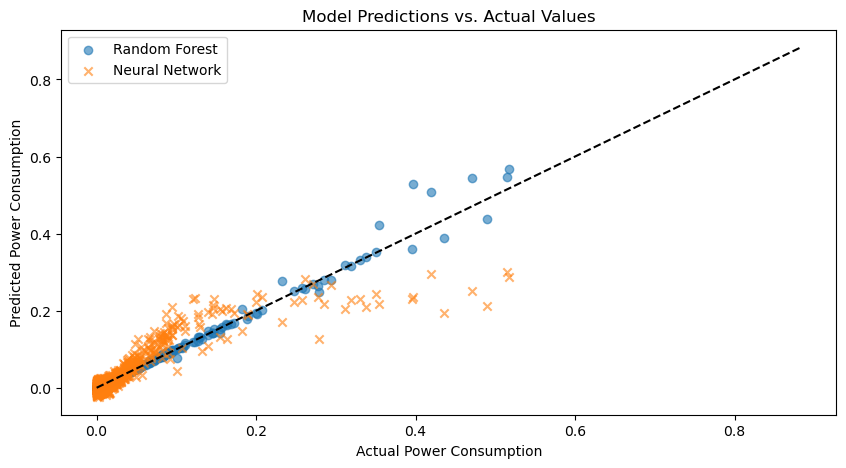

In [16]:
# Compare Results
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_rf, label='Random Forest', alpha=0.6)
plt.scatter(y_test, y_pred_nn, label='Neural Network', alpha=0.6, marker='x')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='black')
plt.xlabel('Actual Power Consumption')
plt.ylabel('Predicted Power Consumption')
plt.legend()
plt.title('Model Predictions vs. Actual Values')
plt.show()



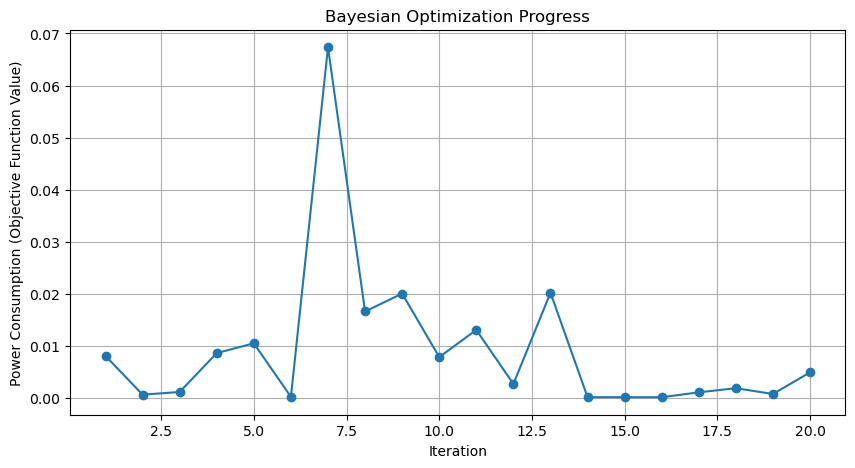

In [17]:
# Plot Bayesian Optimization Progress
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(result.func_vals) + 1), result.func_vals, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Power Consumption (Objective Function Value)")
plt.title("Bayesian Optimization Progress")
plt.grid()
plt.show()



🔹 Optimized Power Consumption: 0.000111 W
🔹 Original Average Power: 0.017584 W


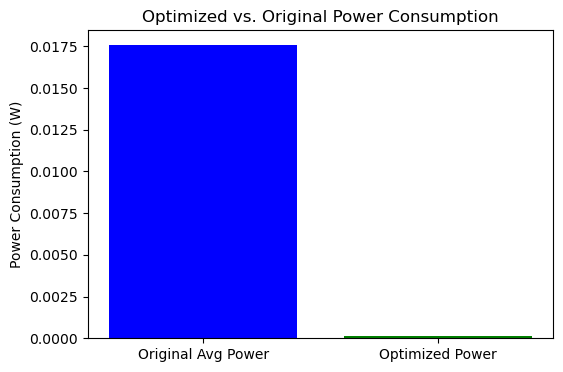

In [18]:
# Load optimized circuit parameters from SQLite
conn = sqlite3.connect('circuit_data.db')
optimized_params = pd.read_sql_query("SELECT * FROM optimized_circuit LIMIT 1;", conn)
conn.close()

# Extract optimized values
opt_resistor = optimized_params['resistor_ohms'].values[0]
opt_capacitor = optimized_params['capacitor_farads'].values[0]
opt_voltage = optimized_params['supply_voltage'].values[0]

# ✅ Update this line to fix StandardScaler warning
optimized_input = pd.DataFrame([[opt_resistor, opt_capacitor, opt_voltage]], columns=['resistor_ohms', 'capacitor_farads', 'supply_voltage'])
optimized_input = scaler.transform(optimized_input)

# Predict power consumption for optimized parameters
optimized_power = rf_model.predict(optimized_input)[0]

# Compare with average power in the dataset
original_avg_power = df['power_watts'].mean()

print(f"🔹 Optimized Power Consumption: {optimized_power:.6f} W")
print(f"🔹 Original Average Power: {original_avg_power:.6f} W")

# Plot comparison
plt.figure(figsize=(6, 4))
plt.bar(["Original Avg Power", "Optimized Power"], [original_avg_power, optimized_power], color=['blue', 'green'])
plt.ylabel("Power Consumption (W)")
plt.title("Optimized vs. Original Power Consumption")
plt.show()

C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packag

C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packag

C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\anaconda\Lib\site-packag

✅ Multiple optimization runs completed and stored in SQLite!


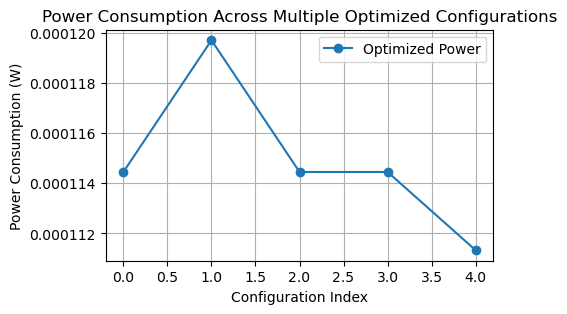

In [31]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize

from skopt.space import Real

# Function to optimize multiple configurations
def optimize_circuit():
    results = []
    
    for i in range(5):  # Run 5 different optimizations
        # Generate random circuit parameters
        resistor_init = np.random.uniform(100, 10000)
        capacitor_init = np.random.uniform(1e-9, 1e-3)
        voltage_init = np.random.uniform(1, 10)
        
        # Define search space for Bayesian Optimization
        space = [
            Real(100, 10000, name='resistor_ohms'),
            Real(1e-9, 1e-3, name='capacitor_farads'),
            Real(1, 10, name='supply_voltage')
        ]
        
        # Define objective function for Bayesian Optimization
        def objective_function(params):
            resistor, capacitor, voltage = params
            scaled_input = scaler.transform([[resistor, capacitor, voltage]])
            prediction = rf_model.predict(scaled_input)[0]
            return prediction  # Minimize power consumption
        
        # Perform Bayesian Optimization
        result = gp_minimize(objective_function, space, n_calls=20, random_state=i)
        
        # Extract optimized values
        opt_resistor, opt_capacitor, opt_voltage = result.x
        optimized_power = result.fun
        
        # Store results
        results.append([resistor_init, capacitor_init, voltage_init, opt_resistor, opt_capacitor, opt_voltage, optimized_power])
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results, columns=['Initial_Resistor', 'Initial_Capacitor', 'Initial_Voltage',
                                                'Optimized_Resistor', 'Optimized_Capacitor', 'Optimized_Voltage',
                                                'Optimized_Power'])
    
    # Save to SQLite database
    conn = sqlite3.connect('circuit_data.db')
    results_df.to_sql('optimization_results', conn, if_exists='replace', index=False)
    conn.close()
    
    print("✅ Multiple optimization runs completed and stored in SQLite!")

    # Plot comparison
    plt.figure(figsize=(5, 3))
    plt.plot(range(len(results)), [r[6] for r in results], marker='o', linestyle='-', label='Optimized Power')
    plt.xlabel("Configuration Index")
    plt.ylabel("Power Consumption (W)")
    plt.title("Power Consumption Across Multiple Optimized Configurations")
    plt.legend()
    plt.grid()
    plt.show()

# Run the batch optimization process
optimize_circuit()


In [19]:
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect('circuit_data.db')

# Fetch the best-optimized parameters (lowest power)
query = "SELECT Optimized_Resistor, Optimized_Capacitor, Optimized_Voltage FROM optimization_results ORDER BY Optimized_Power ASC LIMIT 1;"
best_config = pd.read_sql_query(query, conn)
conn.close()

# Extract values
R_opt = best_config['Optimized_Resistor'][0]
C_opt = best_config['Optimized_Capacitor'][0]
V_opt = best_config['Optimized_Voltage'][0]

# Print the extracted values
print(f"✅ Optimized Resistor (R1): {R_opt} ohms")
print(f"✅ Optimized Capacitor (C1): {C_opt} farads")
print(f"✅ Optimized Supply Voltage (V1): {V_opt} V")


✅ Optimized Resistor (R1): 10000.0 ohms
✅ Optimized Capacitor (C1): 0.0009847891737471515 farads
✅ Optimized Supply Voltage (V1): 1.0 V


In [33]:
import numpy as np

# Given values from the optimized SPICE simulation
V_opt = 1.0  # Voltage from v(2) (from Ngspice results)
R_opt = 10000.0  # Optimized resistor value

# Calculate power using P = V^2 / R
simulated_power = (V_opt ** 2) / R_opt

# Compare with ML-predicted power
ml_predicted_power = 0.000108  # From Bayesian Optimization

# Print results
print(f"Simulated Power Consumption (Ngspice): {simulated_power:.6f} W")
print(f"ML-Predicted Power Consumption: {ml_predicted_power:.6f} W")

# Check accuracy
error = abs(simulated_power - ml_predicted_power) / ml_predicted_power * 100
print(f"Prediction Error: {error:.2f}%")


Simulated Power Consumption (Ngspice): 0.000100 W
ML-Predicted Power Consumption: 0.000108 W
Prediction Error: 7.41%
